## Import libraries

In [1]:
import numpy as np
import re
import math
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import numpy as np
from dataset.utils import load_and_process_data, generate_orth, load_data,extract_features
from dataset.dataset import SyntheticDataset, SimuDataset
from model.linear import ModifiedLinear
from model.shallow import ModifiedShallow
from model.bilinear import ModifiedBiLinear
from strategies.al_sampling import MTALSampling
from strategies.baseline_sampling import RandomSampling
from trainer.pytorch_passive_trainer import PyTorchPassiveTrainer
from trainer.trainer import *
import matplotlib.pyplot as plt

$x \in\mathbb{R}^n$ represents shared features across all tasks. $w \in\mathbb{R}^m$ represents non-shared(environment) variables for each tasks.

We are insterested in system where $f(x,w) = \phi(x) * \phi(w)$. There exists a target task $\phi_x(x_{target}) * \phi_w(w_{target})$. However, there are some limitations to directly access target dataset. We want to sample from some sources tasks that could help us to better learn the representation functions $\phi_x$ and $\phi_w$ for target tasks.

## Load and Process Data

In our case, $\phi_w$ is a linear transformation represented by a matrix $B_w$. There are n source tasks with non-shared environment variable $\{w_1,...,w_n\}$. We generate data according to 

$$y=\phi(x) * B_w * w_i$$

for every task i, where $\phi(x)$ is a MLP model.

Here, with dataset Neural-fly. $x \in\mathbb{R}^{11}$ includes features verlocity(v), attitude(q), motor speed command(pwm). 

Then $\phi(x) \in\mathbb{R}^{11 \times 33} $

There are 33 possible source tasks($w_i \in\mathbb{R}^{33}$ is a one hot vector) with different wind speed $\in\mathbb{R}$ and $fa$ vector $\in\mathbb{R}^3$ , $B_w \in\mathbb{R}^{2 \times 33}$.

The output $y$ is a scalar: $\{ fa_i | i \in [x,y,z] \}$

In [2]:
shared_features = ['v', 'q', 'pwm']
rawdata_nontrans = load_data("./data/training/")
rawdata_transfer = load_data("./data/training-transfer/")


In [3]:
raw_data = rawdata_nontrans + [0] + rawdata_transfer

In [4]:
input_dim = 11 # dim(x)
embed_dim = 2 # dim(\phi(x))
task_dim = 33 # dim(w)
source_task_dict = {}
test_task_dict = {}

In [5]:
input_data = {}
input_label = {}
input_ws = {}
task_embed_matrix = []
fa_list = ["x","y","z"]
transfer = "nontransfer"
w_matrix = np.identity(33)
count = -1
for task_data in raw_data:
   if task_data == 0:
      transfer = "transfer"
      continue
   if task_data["condition"] == "nowind":
      wind_speed = 0
   else:
      wind_speed = re.search(r'\d+', task_data["condition"]).group()
   for dim in range(task_data["fa"].shape[1]):
      # input_data.append(np.array(extract_features(task_data,shared_features)))
      # input_label.append(task_data["fa"][:,dim])
      count += 1
      task_name = f"{transfer}_{wind_speed}_{fa_list[dim]}"
      input_data[task_name] = np.array(extract_features(task_data,shared_features))
      input_label[task_name] = task_data["fa"][:,dim]
      input_ws[task_name] = np.array([w_matrix[count]] * task_data["fa"].shape[0])
      source_task_dict[task_name] = (w_matrix[count],2)
# task_embed_matrix = np.array(task_embed_matrix).T

In [6]:
test_task_dict[list(input_ws.keys())[task_dim-1]] = (w_matrix[task_dim-1],2)

In [7]:
dataset = SimuDataset(input_data, input_label, input_ws)

## Create Training Model

### Uniformly Sampling

Sample the same amount of samples from all source tasks

In [ ]:
trainer_config = {"trainer_name":"pytorch_passive", "max_epoch": 10, "train_batch_size": 1000, "lr": 0.1, "num_workers": 4,\
                  "optim_name": "SGD", "scheduler_name": "StepLR", "step_size": 500, "gamma": 0.1,
                  "test_batch_size": 500}
trainer_config = get_optimizer_fn(trainer_config)
trainer_config = get_scheduler_fn(trainer_config)
model = ModifiedBiLinear(input_dim, task_dim, embed_dim, ret_emb = False)
# model.update_input_embedding(input_embed_matrix)
# model.update_task_embedding(task_embed_matrix)
trainer = PyTorchPassiveTrainer(trainer_config, model)

# Target task only training
total_train_loss = []
total_test_loss = []
for i in range(10):
  trian_loss = trainer.train(dataset, source_task_dict, freeze_rep = False, need_print=True)
  total_train_loss.append(trian_loss)
  test_loss = trainer.test(dataset, test_task_dict)
  total_test_loss.append(test_loss)

In [18]:
strategy = RandomSampling(test_task_dict,1)

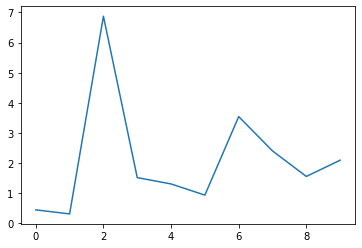

In [14]:
plt.plot(total_test_loss)

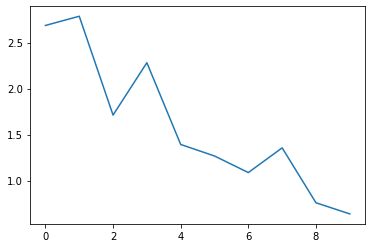

In [15]:
plt.plot(total_train_loss)

In [32]:
b_matrix = model.get_full_task_embed_matrix()
target = b_matrix[:,-1] 
def cos_sim(a):
  cos_sim = np.dot(a, target)/(np.linalg.norm(a) * np.linalg.norm(target))
  return cos_sim

In [41]:
task_name_list = np.array(list(source_task_dict.keys()))

In [35]:
cos_sim = np.apply_along_axis(lambda x: cos_sim(x), 0, b_matrix[:,:-1])

In [37]:
sorted_idx_sim = np.argsort(cos_sim)

In [44]:
print("target task: ", task_name_list[-1])
task_name_list[sorted_idx_sim]

target task:  transfer_10_z


array(['transfer_20_z', 'nontransfer_20_z', 'nontransfer_0_y',
       'nontransfer_10_z', 'transfer_40_z', 'transfer_20_y',
       'transfer_0_x', 'nontransfer_20_x', 'transfer_0_y',
       'transfer_40_y', 'nontransfer_40_z', 'nontransfer_0_z',
       'nontransfer_50_z', 'nontransfer_40_y', 'nontransfer_30_z',
       'transfer_30_z', 'nontransfer_50_x', 'transfer_30_y',
       'nontransfer_10_y', 'nontransfer_0_x', 'nontransfer_20_y',
       'transfer_40_x', 'transfer_10_x', 'nontransfer_30_y',
       'nontransfer_30_x', 'nontransfer_40_x', 'transfer_10_y',
       'transfer_0_z', 'transfer_20_x', 'nontransfer_10_x',
       'transfer_30_x', 'nontransfer_50_y'], dtype='<U16')

### Actively sampling

In [ ]:
trainer_config = {"trainer_name":"pytorch_passive", "max_epoch": 10, "train_batch_size": 1000, "lr": 0.1, "num_workers": 4,\
                  "optim_name": "SGD", "scheduler_name": "StepLR", "step_size": 500, "gamma": 0.1,
                  "test_batch_size": 500}
trainer_config = get_optimizer_fn(trainer_config)
trainer_config = get_scheduler_fn(trainer_config)
model = ModifiedBiLinear(input_dim, task_dim, embed_dim, ret_emb = False)
# model.update_input_embedding(input_embed_matrix)
# model.update_task_embedding(task_embed_matrix)
trainer = PyTorchPassiveTrainer(trainer_config, model)

# Target task only training
strategy = MTALSampling()
total_train_loss = []
total_test_loss = []
for i in range(10):
  trian_loss = trainer.train(dataset, source_task_dict, freeze_rep = False, need_print=True)
  #TODO: change the pseudo-code
  new_weight = strategy.select()
  source_task_dict.update(new_weight)
  #
  total_train_loss.append(trian_loss)
  test_loss = trainer.test(dataset, test_task_dict)
  total_test_loss.append(test_loss)